## 1. Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm, catboost as catb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from scipy.stats import mannwhitneyu

%matplotlib inline

In [2]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data


### Описание полей датасета

- Home Ownership - домовладение
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита
- Term - срок кредита
- Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
- Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
- Monthly Debt - ежемесячный долг
- Credit Score - баллы кредитного рейтинга
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Путь к данным

In [5]:
TRAIN_PATH = 'C:/ulka/cp2/train.csv'
TEST_PATH = 'C:/ulka/cp2/test.csv'
SUBMISSION = 'C:/ulka/cp2/submission.csv'

## 2. Загрузка данных

In [6]:
test_df = pd.read_csv(TEST_PATH)
df = pd.read_csv(TRAIN_PATH)

In [7]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [8]:
df.info()
#есть пропущенные значения в признаках Annual Income, Years in current job, Months since last delinquent,
#Bankruptcies, Credit Score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [9]:
#посмотрим типы признаков
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [10]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


В признаках Maximum Open Credit, Current Loan Amount и Credit Score скорее всего есть выбросы, так как медиана достаточно сильно отличается от 50 персентиля.

## 3. EDA

Рассмотрим распределение целевой переменной.

Text(0.5, 1.0, 'Distribution of the target feature')

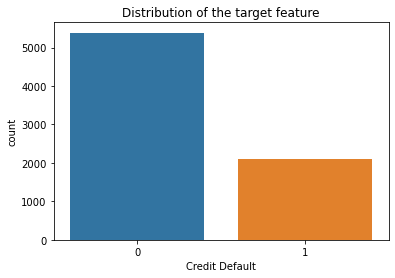

In [11]:
sns.countplot(x=df['Credit Default'])
plt.title('Distribution of the target feature')

Видим, что 0 намного больше чем 1, то есть существует дисбаланс классов.

Рассмотрим рапределения признаков количественных признаков.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018EA7CEA2E0>,
      dtype=object)

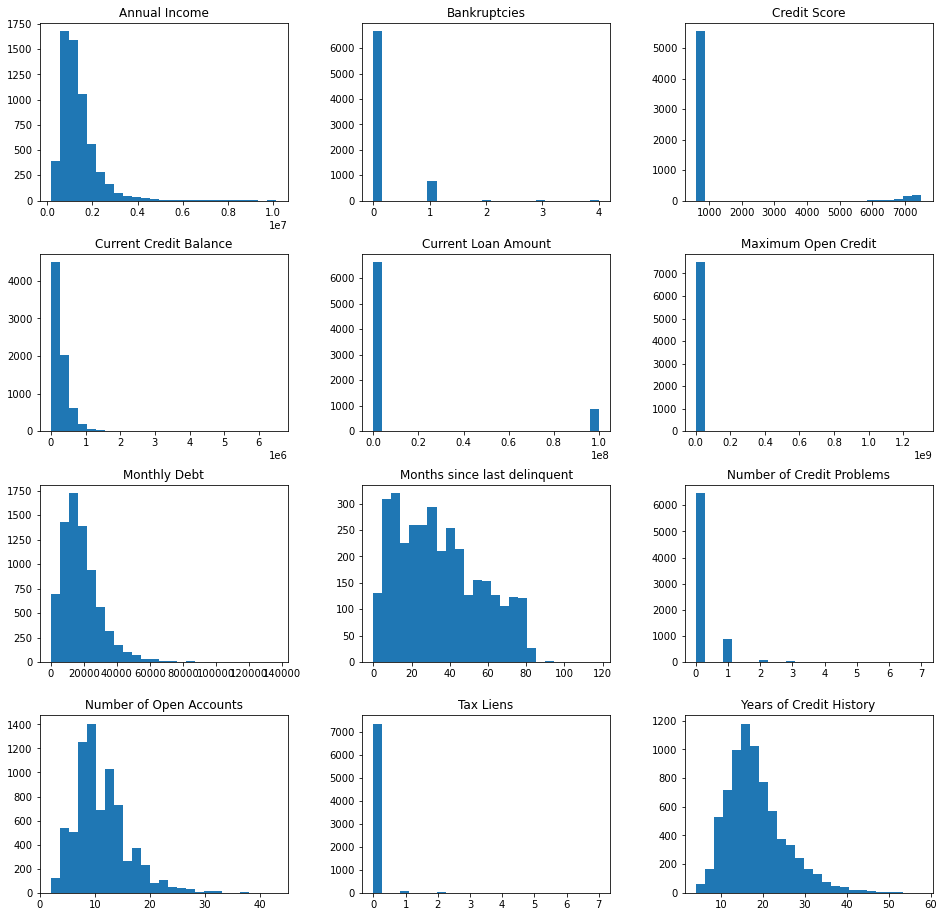

In [12]:
df.select_dtypes(include='float64').hist(figsize=(16,16), bins=25, grid=False, log=False)

Рассмотрим категориальные переменные

In [13]:
df.select_dtypes(include='object').columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

Посмотрим на графике распределение категориальных переменных 'Home Ownership', 'Years in current job', 'Purpose', 'Term'

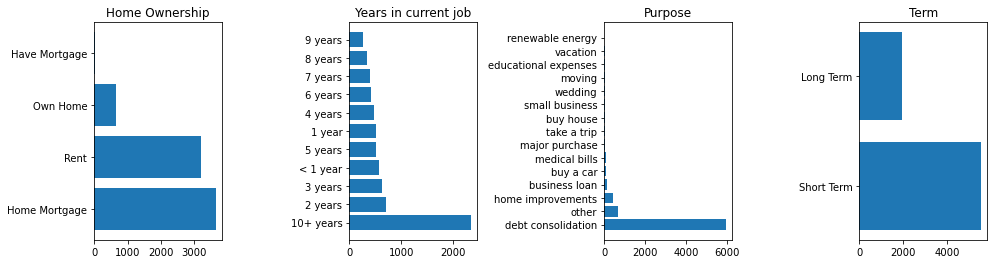

In [14]:
f = plt.figure(figsize=(16,4))
#plt.yscale('log')
ax1 = f.add_subplot(141)
x = df['Home Ownership'].value_counts().index
y = df['Home Ownership'].value_counts()
plt.barh(x, y)
ax1.set_title('Home Ownership')

ax2 = f.add_subplot(142)
x = df['Years in current job'].value_counts().index
y = df['Years in current job'].value_counts()
plt.barh(x, y)
ax2.set_title('Years in current job')

ax3 = f.add_subplot(143)
x = df['Purpose'].value_counts().index
y = df['Purpose'].value_counts()
plt.barh(x, y)
ax3.set_title('Purpose')

ax3 = f.add_subplot(144)
x = df['Term'].value_counts().index
y = df['Term'].value_counts()
plt.barh(x, y)
ax3.set_title('Term')

plt.subplots_adjust(wspace=1, hspace=4)

plt.show()

Для Purpose все признаки кроме debt consolidation можно заменить на others.
Для Home Ownership - очень мало значений Have Mortgage. 
Years in current job нужно заменить на количественный признак.

Построим матрицу корреляций.

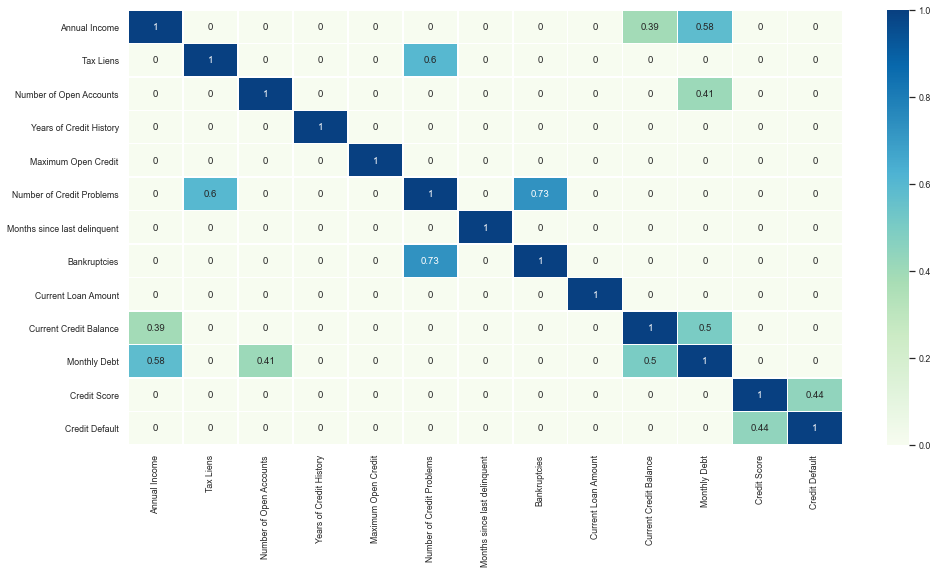

In [15]:
df_corr = df.corr()
import seaborn as sns
plt.figure(figsize = (16,8))
sns.set(font_scale=0.8)
df_corr_round = np.round(df_corr, 2)
df_corr_round[np.abs(df_corr) < 0.3] = 0
sns.heatmap(df_corr_round, annot=True, linewidths=.5, cmap='GnBu')
plt.show()

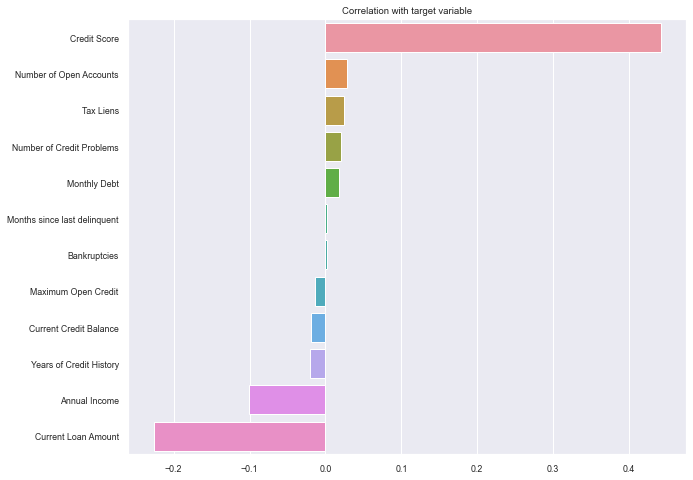

In [16]:
#Построим матрицу корреляций признаков и целевой переменной.

TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Самое большое влияние имеет признак Credit Score, Current Loan Amount и Annual income.

## 4. Проверка похожести признаков Train и Test

In [17]:
df_test = pd.read_csv(TEST_PATH, sep=',')
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


Проверим на похожесть вещественные признаки

In [18]:
count_feature_names = df.select_dtypes(include='float64').columns.tolist()

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


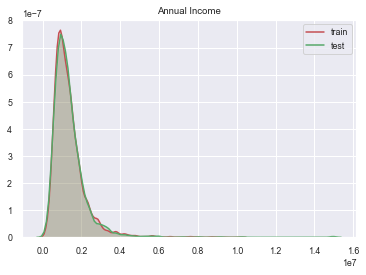

C:\Users\ulavi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ulavi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


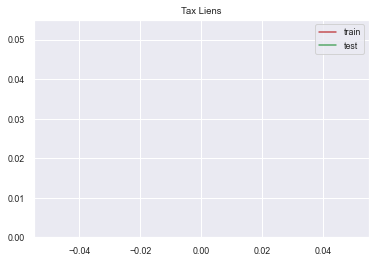

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


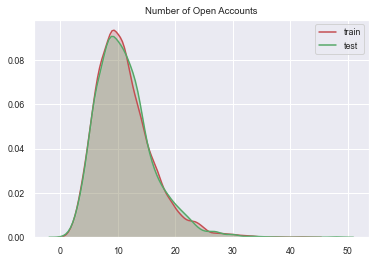

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


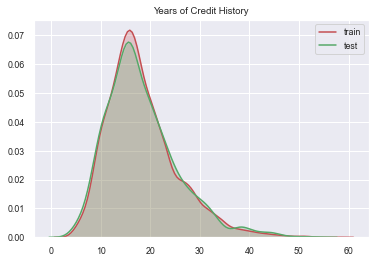

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


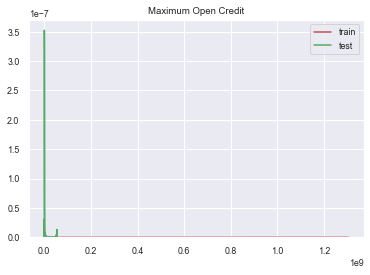

C:\Users\ulavi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ulavi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


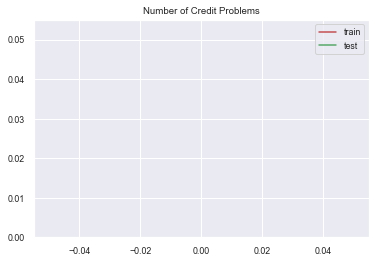

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


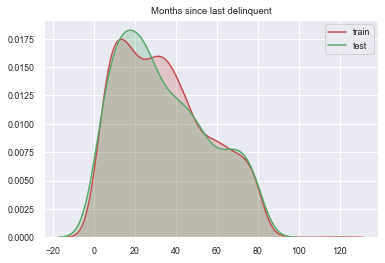

C:\Users\ulavi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ulavi\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


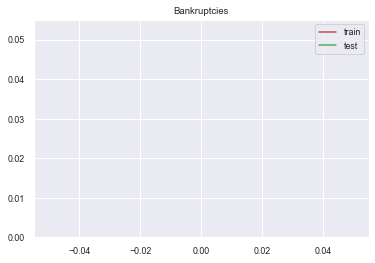

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


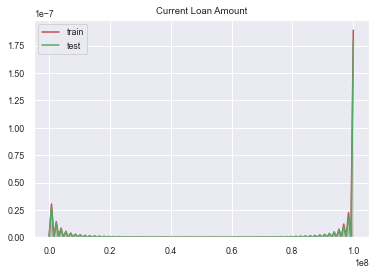

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


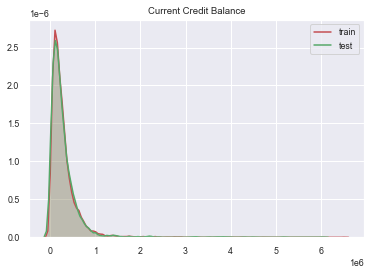

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


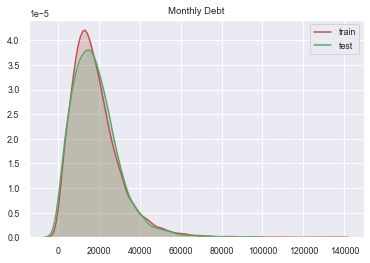

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


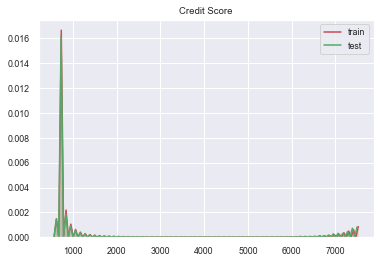

In [19]:
figsize = (6, 4)
for col in count_feature_names:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

Похожи.

Проверим на похожесть категориальные признаки

In [20]:
cat_feature_names = df.select_dtypes(include='object').columns.tolist()

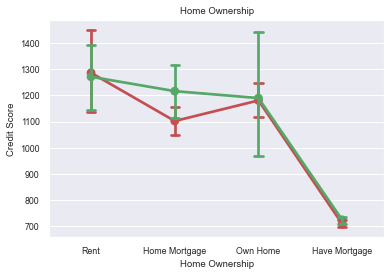

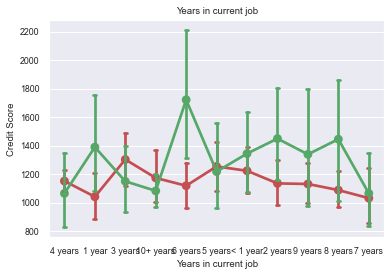

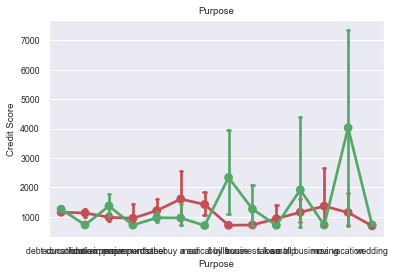

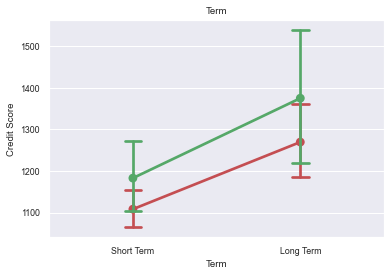

In [21]:
num_feature = 'Credit Score'
for col in cat_feature_names:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

По всем признакам есть совпадение.

## 5. Предобработка данных (выбросы и пропуски) и Feature engineering

In [22]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.max_open_cred_3q = None
        self.median_loan_by_purpose = None
        self.monthly_debt_q50 = None
        self.monthly_debt_q975 = None
        self.annual_income_q50 = None
        self.annual_income_q975 = None
        self.annual_income_q100 = None
        self.median_сredit_score_by_term_ownership = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.max_open_cred_3q = np.quantile(X['Maximum Open Credit'], q=0.9996)
        self.median_loan_by_purpose = X.groupby('Purpose', as_index=False).agg({'Current Loan Amount':'median'})
        self.monthly_debt_q975 = np.quantile(X['Monthly Debt'], q=0.975)
        self.monthly_debt_q50 = np.quantile(X['Monthly Debt'], q=0.50)   
        self.annual_income_q50 = X.loc[(X['Monthly Debt']<self.monthly_debt_q50),'Annual Income'].median()
        self.annual_income_q975 = X.loc[(X['Monthly Debt']<self.monthly_debt_q975),'Annual Income'].median()
        self.annual_income_q100 = X.loc[(X['Monthly Debt']>self.monthly_debt_q975),'Annual Income'].median()
        self.median_сredit_score_by_term_ownership = X.groupby(by=['Home Ownership','Term'])\
                                                      .agg({'Credit Score':'median'})\
                                                      .rename(columns={'Credit Score':'Credit Score Med'})
        
    def transform(self, X):
        """Трансформация данных"""

        # Maximum Open Credit
        # убираем совсем большие значения
        X.loc[(X['Maximum Open Credit']>self.max_open_cred_3q), 'Maximum Open Credit'] = X['Maximum Open Credit'].median()
      
        # Current Loan Amount
        # Значение 99999999 выглядит неадекватно. Заменим на медиану в зависимости от цели кредита.      
        for purpose in self.median_loan_by_purpose['Purpose']:
            x1 = self.median_loan_by_purpose.loc[self.median_loan_by_purpose['Purpose']==purpose, 'Current Loan Amount'].values[0]
            X.loc[(X['Current Loan Amount']==99999999) & (X['Purpose']==str(purpose)), 'Current Loan Amount'] = x1
        
        # Credit Score
        # делим на 10 значения больше 1000
        X.loc[(X['Credit Score']>1000), 'Credit Score'] = X.loc[(X['Credit Score']>1000), 'Credit Score'] /10
        
        # Annual Income
        # заполним пропуски в соответсвии с Monthly Debt
        X.loc[(X['Monthly Debt']<self.monthly_debt_q50) & (X['Annual Income'].isna()),'Annual Income'] =  self.annual_income_q50
        X.loc[(X['Monthly Debt']<self.monthly_debt_q975) & (X['Annual Income'].isna()),'Annual Income'] =  self.annual_income_q975
        X.loc[(X['Monthly Debt']>self.monthly_debt_q975) & (X['Annual Income'].isna()),'Annual Income'] =  self.annual_income_q100
        
        # Years in current job
        # Заполним признак Years in current job 2 годами, чтобы не слишком доверять этому значению.
        # теоретически чем меньше кол-во лет работы, тем меньше кредитный скоринг
        X['JobYearsUnknown'] = 1 * (X['Years in current job'].isna())
        X.loc[(X['Years in current job'].isna()),'Years in current job'] = '2 years'
                
        # Months since last delinquent
        # заполним нулями, скорей всего, если пропуск, значит просрочек не было
        X.loc[(X['Months since last delinquent'].isna()),'Months since last delinquent'] = 0
                
        # Bankruptcies
        X.loc[(df['Bankruptcies'].isna()),'Bankruptcies'] = 0
                
        # Tax Liens
        # приводим к бинарному виду, есть налоги или нет
        X.loc[df['Tax Liens'] > 0, 'Tax Liens'] = 1
        
        # Credit Score
        
        # не получилось прикрутить в класс функцию imputer_rfr. ошибки выдает.
        #df_copy = X.copy()
        #feature_name = 'Credit Score'
        #df_copy = df_copy.drop(columns=['Home Ownership','Years in current job','Purpose','Term'])
        #score_predictor, df_copy = imputer_rfr(df_copy, feature_name)
        #X['Credit Score'] = df_copy['Credit Score']
        #
        
        # Credit Score
        # так что заполним Credit Score медианой в зависимости от Home Ownership, Term
        X = X.merge(self.median_сredit_score_by_term_ownership, 
                    on=(['Home Ownership','Term']), 
                    how = 'left')
        X.loc[(X['Credit Score'].isna()),'Credit Score'] = X['Credit Score Med']       
        
        X.fillna(self.medians, inplace=True)  
        
        return X

In [23]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.median_credit_default_by_problem_bankruptcies = None
        self.median_credit_default_by_problem_bankruptcies_median = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Target encoding
        df_copy = X.copy()
            
        ## Number of Credit Problems, Bankruptcies
        if y is not None:
            df_copy['Credit Default'] = y.values
            self.median_credit_default_by_problem_bankruptcies = df_copy.groupby(['Number of Credit Problems','Bankruptcies'], as_index=False)\
                                                                        .agg({'Credit Default':'median'})\
                                                                        .rename(columns={'Credit Default':'Med_Credit_Default_By_Problems_Bankruptcies'})
            self.median_credit_default_by_problem_bankruptcies_median = self.median_credit_default_by_problem_bankruptcies['Med_Credit_Default_By_Problems_Bankruptcies']\
                                                                            .median()
          
    def transform(self, X):
        
        # Binary features
        
        # Term
        # Преобразуем Term в бинарный вид
        X['Term'] = X['Term'].replace({'Short Term':0, 'Long Term':1})
        
        # Преобразуем Purpose в бинарный вид
        X.loc[(X['Purpose'] == 'debt consolidation'), 'Purpose'] = 1
        X.loc[~(X['Purpose'] == 1), 'Purpose'] = 0
        
        #Преобразуем Home Ownership, добавив Dummy переменные
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        
        # Bankruptcies приводим к бинарному виду (есть факт банкротства или нет)
        X.loc[df['Bankruptcies'] > 0, 'Bankruptcies'] = 1
        
        # Feature encoding
        # Years in current job
        X['Years in current job'] = X['Years in current job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
        
        # Target encoding
        if self.median_credit_default_by_problem_bankruptcies is not None:
            X = X.merge(self.median_credit_default_by_problem_bankruptcies, 
                        on=['Number of Credit Problems','Bankruptcies'], 
                        how='left')
            X.fillna({'Med_Credit_Default_By_Problems_Bankruptcies': self.median_credit_default_by_problem_bankruptcies_median}, inplace=True)
                 
        X.drop('Home Ownership', axis=1, inplace=True)    
        
        return X



## 6. Обучение модели

In [24]:
feature_names = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies',
 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Years in current job', 'Purpose']

target_name = TARGET_NAME

new_feature_names = df.columns.drop(feature_names + [target_name]).to_list()

In [25]:
new_feature_names

['Home Ownership', 'Term']

In [26]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [28]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape


C:\Users\ulavi\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-22-927c5cc6f4fc>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['JobYearsUnknown'] = 1 * (X['Years in current job'].isna())


((5025, 18), (2475, 18), (2500, 18))

In [29]:
X_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,JobYearsUnknown,Credit Score Med
0,Home Mortgage,1008748.0,2 years,0.0,10.0,17.6,328064.0,0.0,2.0,0.0,debt consolidation,Short Term,326579.0,186713.0,13198.0,729.0,0,738.0
1,Rent,2237136.0,10+ years,0.0,10.0,23.6,1639792.0,0.0,0.0,0.0,debt consolidation,Short Term,604428.0,543818.0,38031.0,749.0,0,733.0
2,Home Mortgage,1479245.0,4 years,0.0,11.0,15.3,604824.0,0.0,0.0,0.0,debt consolidation,Short Term,428208.0,375554.0,10712.0,692.0,0,738.0
3,Rent,852777.0,5 years,0.0,16.0,5.8,516142.0,0.0,0.0,0.0,debt consolidation,Short Term,326579.0,172501.0,16132.0,720.0,0,733.0
4,Home Mortgage,768360.0,1 year,0.0,6.0,11.0,315722.0,0.0,0.0,0.0,debt consolidation,Short Term,213532.0,179417.0,4604.0,718.0,0,738.0


In [30]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((5025, 22), (2475, 22), (2500, 22))

In [31]:
X_train.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,...,Current Credit Balance,Monthly Debt,Credit Score,JobYearsUnknown,Credit Score Med,Have Mortgage,Home Mortgage,Own Home,Rent,Med_Credit_Default_By_Problems_Bankruptcies
0,1008748.0,2,0.0,10.0,17.6,328064.0,0.0,2.0,1.0,1,...,186713.0,13198.0,729.0,0,738.0,0,1,0,0,0.0
1,2237136.0,10,0.0,10.0,23.6,1639792.0,0.0,0.0,0.0,1,...,543818.0,38031.0,749.0,0,733.0,0,0,0,1,0.0
2,1479245.0,4,0.0,11.0,15.3,604824.0,0.0,0.0,0.0,1,...,375554.0,10712.0,692.0,0,738.0,0,1,0,0,0.0
3,852777.0,5,0.0,16.0,5.8,516142.0,0.0,0.0,1.0,1,...,172501.0,16132.0,720.0,0,733.0,0,0,0,1,0.0
4,768360.0,1,0.0,6.0,11.0,315722.0,0.0,0.0,0.0,1,...,179417.0,4604.0,718.0,0,738.0,0,1,0,0,0.0


In [32]:
X_train = X_train[test_df.columns.to_list()]
X_valid = X_valid[test_df.columns.to_list()]

X_train.shape, X_valid.shape, test_df.shape

((5025, 22), (2475, 22), (2500, 22))

In [33]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5537482319660536

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=50,
                                     max_depth=5,
                                     min_data_in_leaf=5)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

In [ ]:
submit = pd.read_csv(SUBMISSION)

submit.head()

In [ ]:
predictions = model_catb.predict(test_df)
predictions

In [ ]:
submit.shape

In [ ]:
submit.to_csv('submit2.csv', index=False)